## Marketing Data Analysis Project 

### Description
The objective of this project is to provide data-driven recommendations on the effectiveness of recent advertising campaigns as well as ask and answer questions about the performance of a grocery chain. The deliverable is this notebook. <br> <br>
This notebook is divided into four sections:
1) Exploratory Data Analysis  
2) Statistical Analysis  
3) Data Visualization  
4) A Predictive Model 

#### The Dataset:
- ID: a customer's unique ID
- Year_Birth: year of birth
- Education: highest level of education completed by customer
- Martial_Status: marital status of customer
- Income: customer's yearly household income
- Kidhome: number of small children in customer's household
- Teenhome: number of teenagers in customer's household
- DtCustomer: date of customer's enrollment with the company
- Recency: number of days since the last purchase
- MntWines: amount spent on wines in the last 2 years
- MntFruits: amount spent on fruits in the last 2 years
- MntMeatProducts: amount spent on meat products in the last 2 years
- MntFishProducts: amount spent on fish products in the last 2 years
- MntSweetProducts: amount spent on sweet products in the last 2 years
- MntGoldProds: amount spent on "gold" products in the last 2 years
- NumDealsPurchases: number of purchases made with discount
- NumWebPurchases: number of purchases made through company's web site
- NumCatalogPurchases: number of purchases made using catalogue
- NumStorePurchases: number of purchases made directly in stores
- NumWebVisitsMonth: number of visits to company's web site in the last month
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- Response (target): 1 if customer accepted the offer in the last campaign, 0 otherwise
- Complain: 1 if customer complained in the last 2 years
- Country: the country a customer lives in

These data and the questions asked about them are derived from: https://www.kaggle.com/datasets/jackdaoud/marketing-data

#### Useful Flags:

In [566]:
# flag, when true, prints regression output
global verbose
verbose = False

In [567]:
# flag, when true, creates and saves correlation matrix to csv file
global saveCorrelationMatrix
saveCorrelationMatrix = False

In [568]:
# flag, when true, displays regression residual plots
global residualPlots
residualPlots = False

#### Libraries:

In [569]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

### Section 01: Exploratory Data Analysis

#### Questions:
- Are there any null values or outliers? How will you wrangle/handle them?
- Are there any variables that warrant transformations?
- Are there any useful variables that you can engineer with the given data?
- Do you notice any patterns or anomalies in the data? Can you plot them?

import data for use

In [570]:
url = "https://raw.githubusercontent.com/17jotomp/MDA/main/marketing_data.csv"
df = pd.read_csv(url,index_col=0)

convert data types

In [571]:
df.dtypes

Year_Birth              int64
Education              object
Marital_Status         object
 Income                object
Kidhome                 int64
Teenhome                int64
Dt_Customer            object
Recency                 int64
MntWines                int64
MntFruits               int64
MntMeatProducts         int64
MntFishProducts         int64
MntSweetProducts        int64
MntGoldProds            int64
NumDealsPurchases       int64
NumWebPurchases         int64
NumCatalogPurchases     int64
NumStorePurchases       int64
NumWebVisitsMonth       int64
AcceptedCmp3            int64
AcceptedCmp4            int64
AcceptedCmp5            int64
AcceptedCmp1            int64
AcceptedCmp2            int64
Response                int64
Complain                int64
Country                object
dtype: object

In [572]:
# make income type float and rename column
df.rename(columns={" Income ":"Income"},inplace=True)
df['Income'] = df['Income'].replace('[\$,]', '', regex=True).astype(float)

In [573]:
# convert to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

fix rows with null values

In [574]:
null_sum = df.isnull().sum()
print(null_sum)

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
Complain                0
Country                 0
dtype: int64


In [575]:
# Replace NaNs in 'Income' column with the
# mean of values in the same column
mean_value=df['Income'].mean()
df['Income'].fillna(value=mean_value, inplace=True)

deal with outliers

<AxesSubplot:xlabel='Year_Birth'>

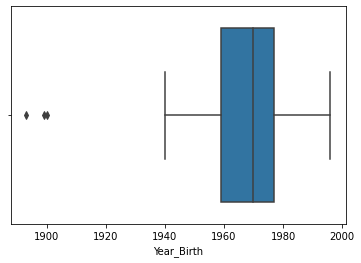

In [576]:
# use boxplot for date of birth outliers
sns.boxplot(x=df['Year_Birth'])

In [577]:
# delete outliers. Assume outliers are clerical error
df = df[df.Year_Birth > 1920]

<AxesSubplot:xlabel='Income'>

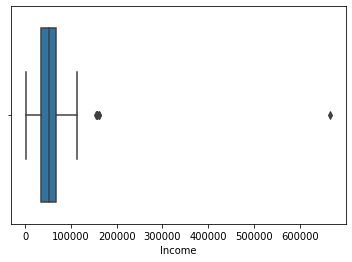

In [578]:
# use boxplot for income outliers.
sns.boxplot(x=df['Income']) 

In [579]:
df = df[df.Income < 400000] #delete outlier

transform variables

In [580]:
df.Education.unique()

array(['Graduation', 'PhD', '2n Cycle', 'Master', 'Basic'], dtype=object)

In [581]:
# combine education categories that represent equivalent education attainment
df.replace("2n Cycle","Masters",inplace=True)
df.replace("Master","Masters",inplace=True)
df.replace("Graduation","Undergraduate",inplace=True)
df.replace("Basic","High_school",inplace=True)

In [582]:
df.Marital_Status.unique()

array(['Divorced', 'Single', 'Married', 'Together', 'Widow', 'YOLO',
       'Alone', 'Absurd'], dtype=object)

In [583]:
# combine marital status categories that represent equivalent status and delete entries with invalid status
df = df[df.Marital_Status != "Absurd"]
df = df[df.Marital_Status != "YOLO"]
df.replace("Alone","Single",inplace=True)
df.replace("Together","Married",inplace=True)

create dummies

In [584]:
df = pd.get_dummies(df)

In [585]:
# rename dummies
df.rename(columns={'Education_High_school':'High_school',
                   'Education_Masters':'Masters',
                   'Education_PhD':'PhD',
                   'Education_Undergraduate':'Undergraduate',
                   'Marital_Status_Divorced':'Divorced',
                   'Marital_Status_Married':'Married',
                   'Marital_Status_Single':'Single',
                   'Marital_Status_Widow':'Widow',
                   'Country_AUS':'AUS',
                   'Country_CA':'CA',
                   'Country_GER':'GER',
                   'Country_IND':'IND',
                   'Country_ME':'ME',
                   'Country_SA':'SA',
                   'Country_SP':'SP',
                   'Country_US':'US'},
          inplace=True)

create useful variable: <br>
- MntTotal Products - The total amount spent by customer on all products in past two years

In [586]:
# create a new categorical variable: MntTotalProducts that is the amount spent on all products in the past two years
df = df.assign(MntTotalProducts = (df.MntWines + df.MntFruits + df.MntMeatProducts + 
                                   df.MntFishProducts + df.MntSweetProducts + df.MntGoldProds))

patterns and anomalies

<AxesSubplot:title={'center':'Teenhome'}, xlabel='Kids', ylabel='No. Customers'>

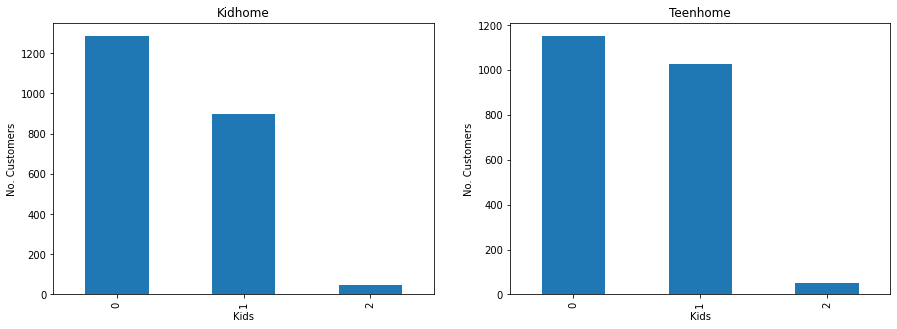

In [587]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

df['Kidhome'].value_counts().plot.bar(ax=axs[0],title='Kidhome',xlabel='Kids',ylabel='No. Customers')
df['Teenhome'].value_counts().plot.bar(ax=axs[1],title='Teenhome',xlabel='Kids',ylabel='No. Customers')

No household has more than two children or teenagers. Measurement error?

How are the data distributed?

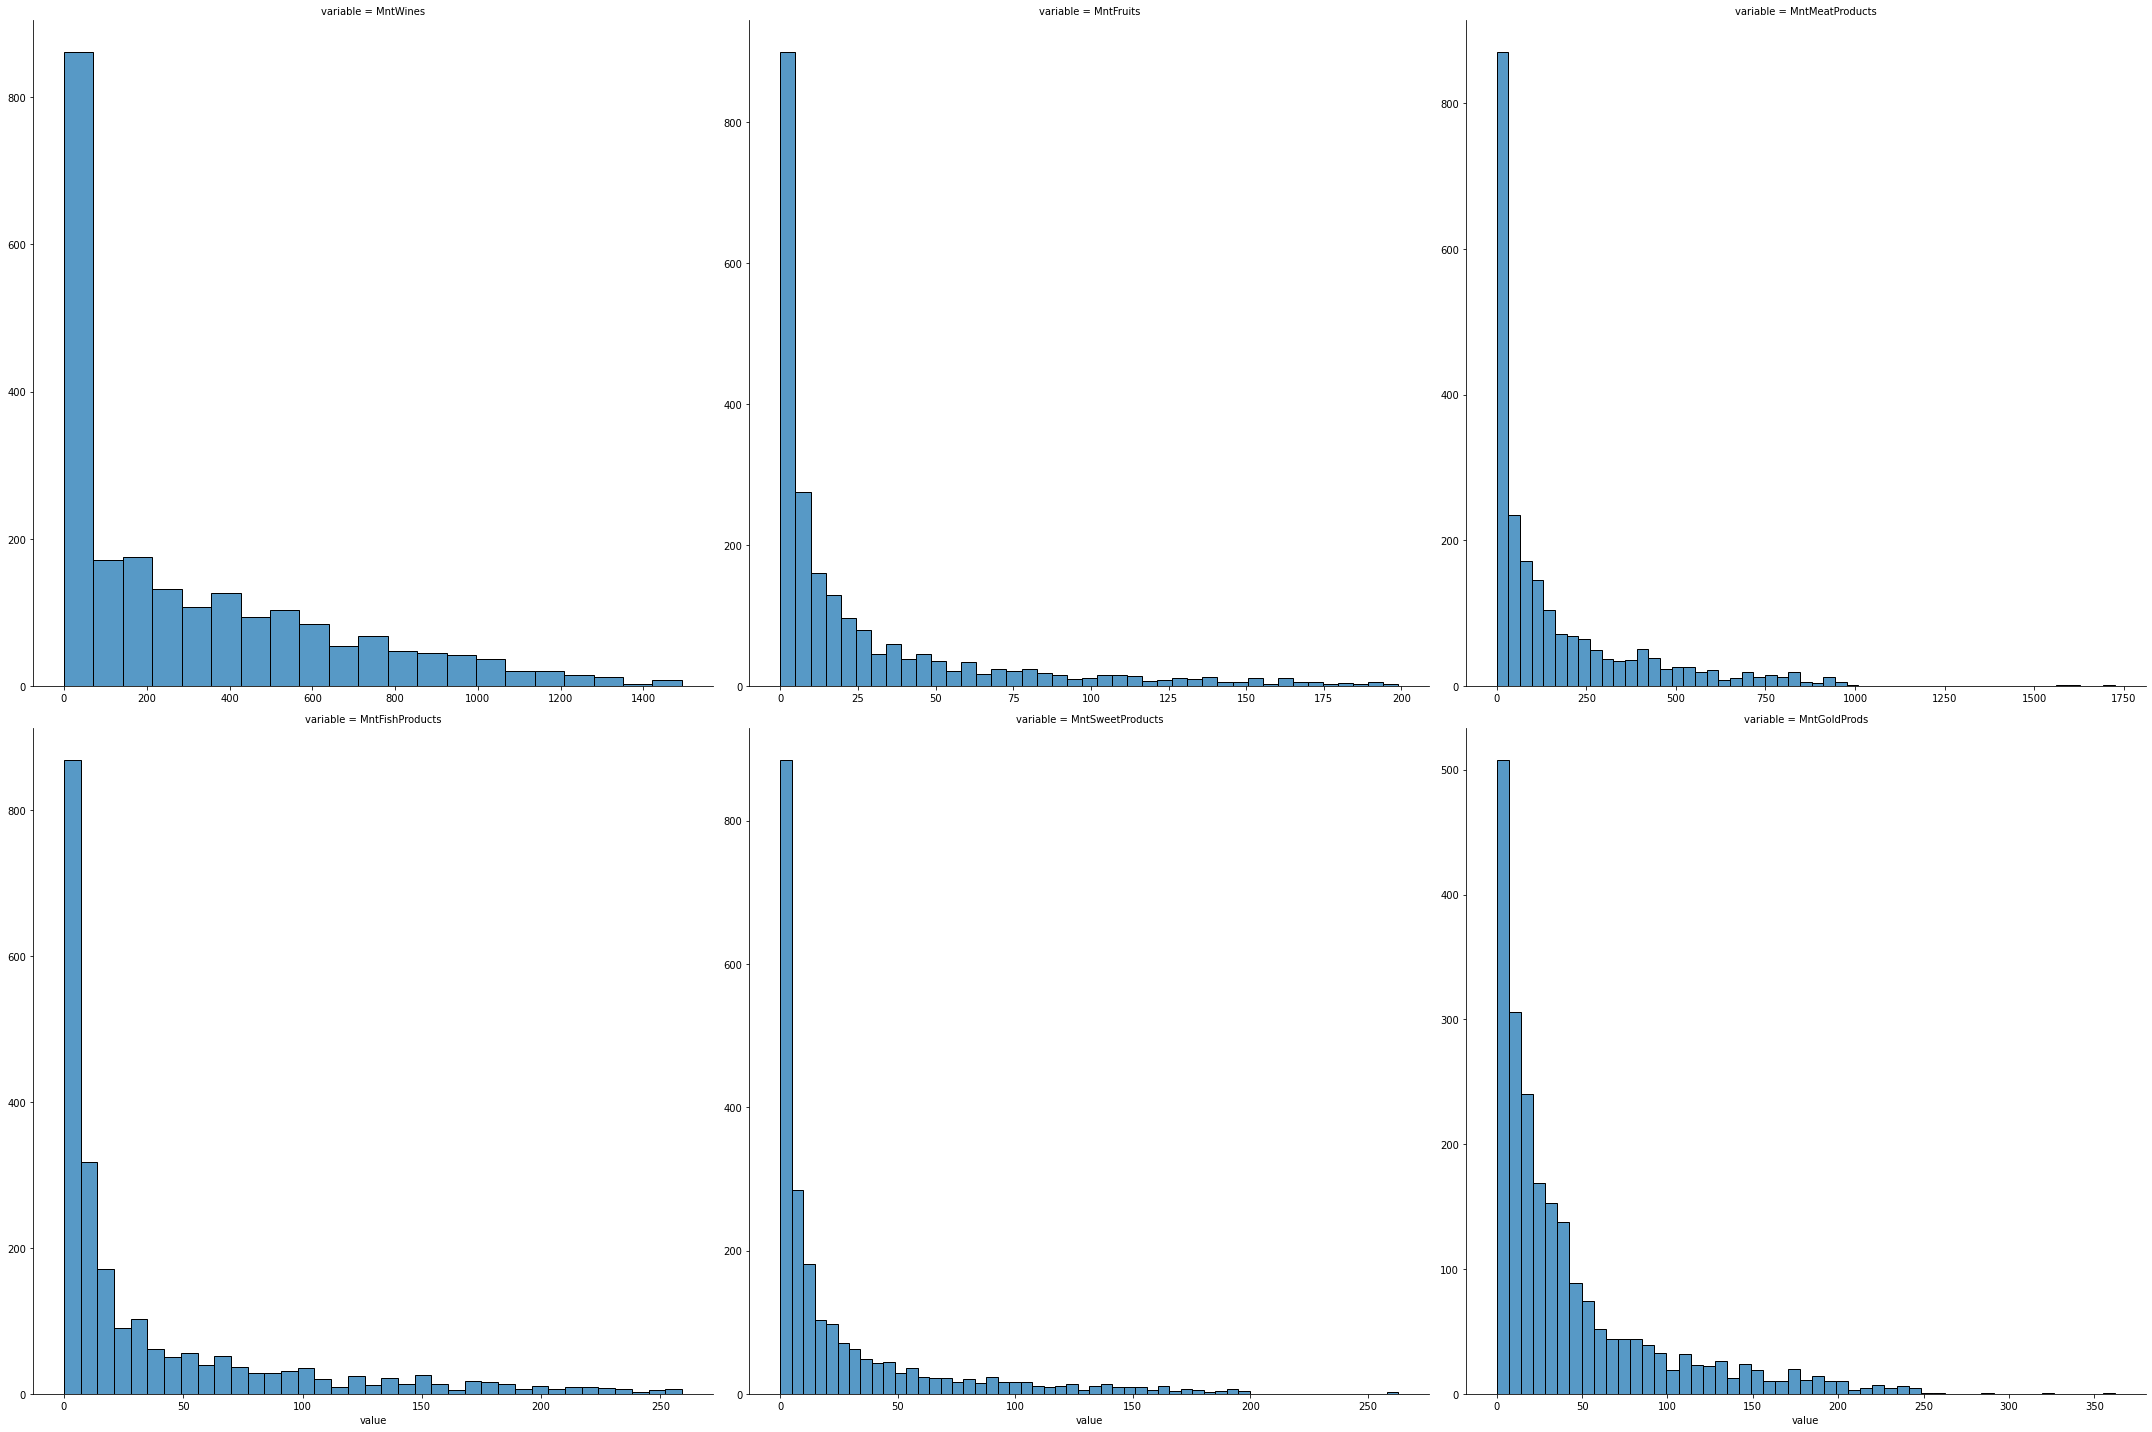

In [588]:
data_distribution = pd.DataFrame(data=df, columns=['MntWines','MntFruits','MntMeatProducts',
                                                   'MntFishProducts','MntSweetProducts',
                                                   'MntGoldProds'
                                                  ])

nd = pd.melt(data_distribution, value_vars = data_distribution )
n1 = sns.FacetGrid (nd, col='variable', col_wrap = 3, height = 10, sharex=False, sharey = False)
n1 = n1.map(sns.histplot, 'value')

The data are highly skewed and should be transformed for OLS

In [589]:
transformed_df = df.copy()
to_be_transformed = ['MntFruits','MntWines', 'MntMeatProducts', 'MntFishProducts', 'MntGoldProds', 'MntTotalProducts','MntSweetProducts']
ending_transformed = "_transformed"
logged_names = []
for var in to_be_transformed:
    logged_names.append(var+ending_transformed)
    transformed_df[var+ending_transformed] = (np.power(transformed_df[var]+0.5,(1/10))) # (x + 0.5)^(1/10)
    transformed_df.drop(var, inplace=True, axis=1)

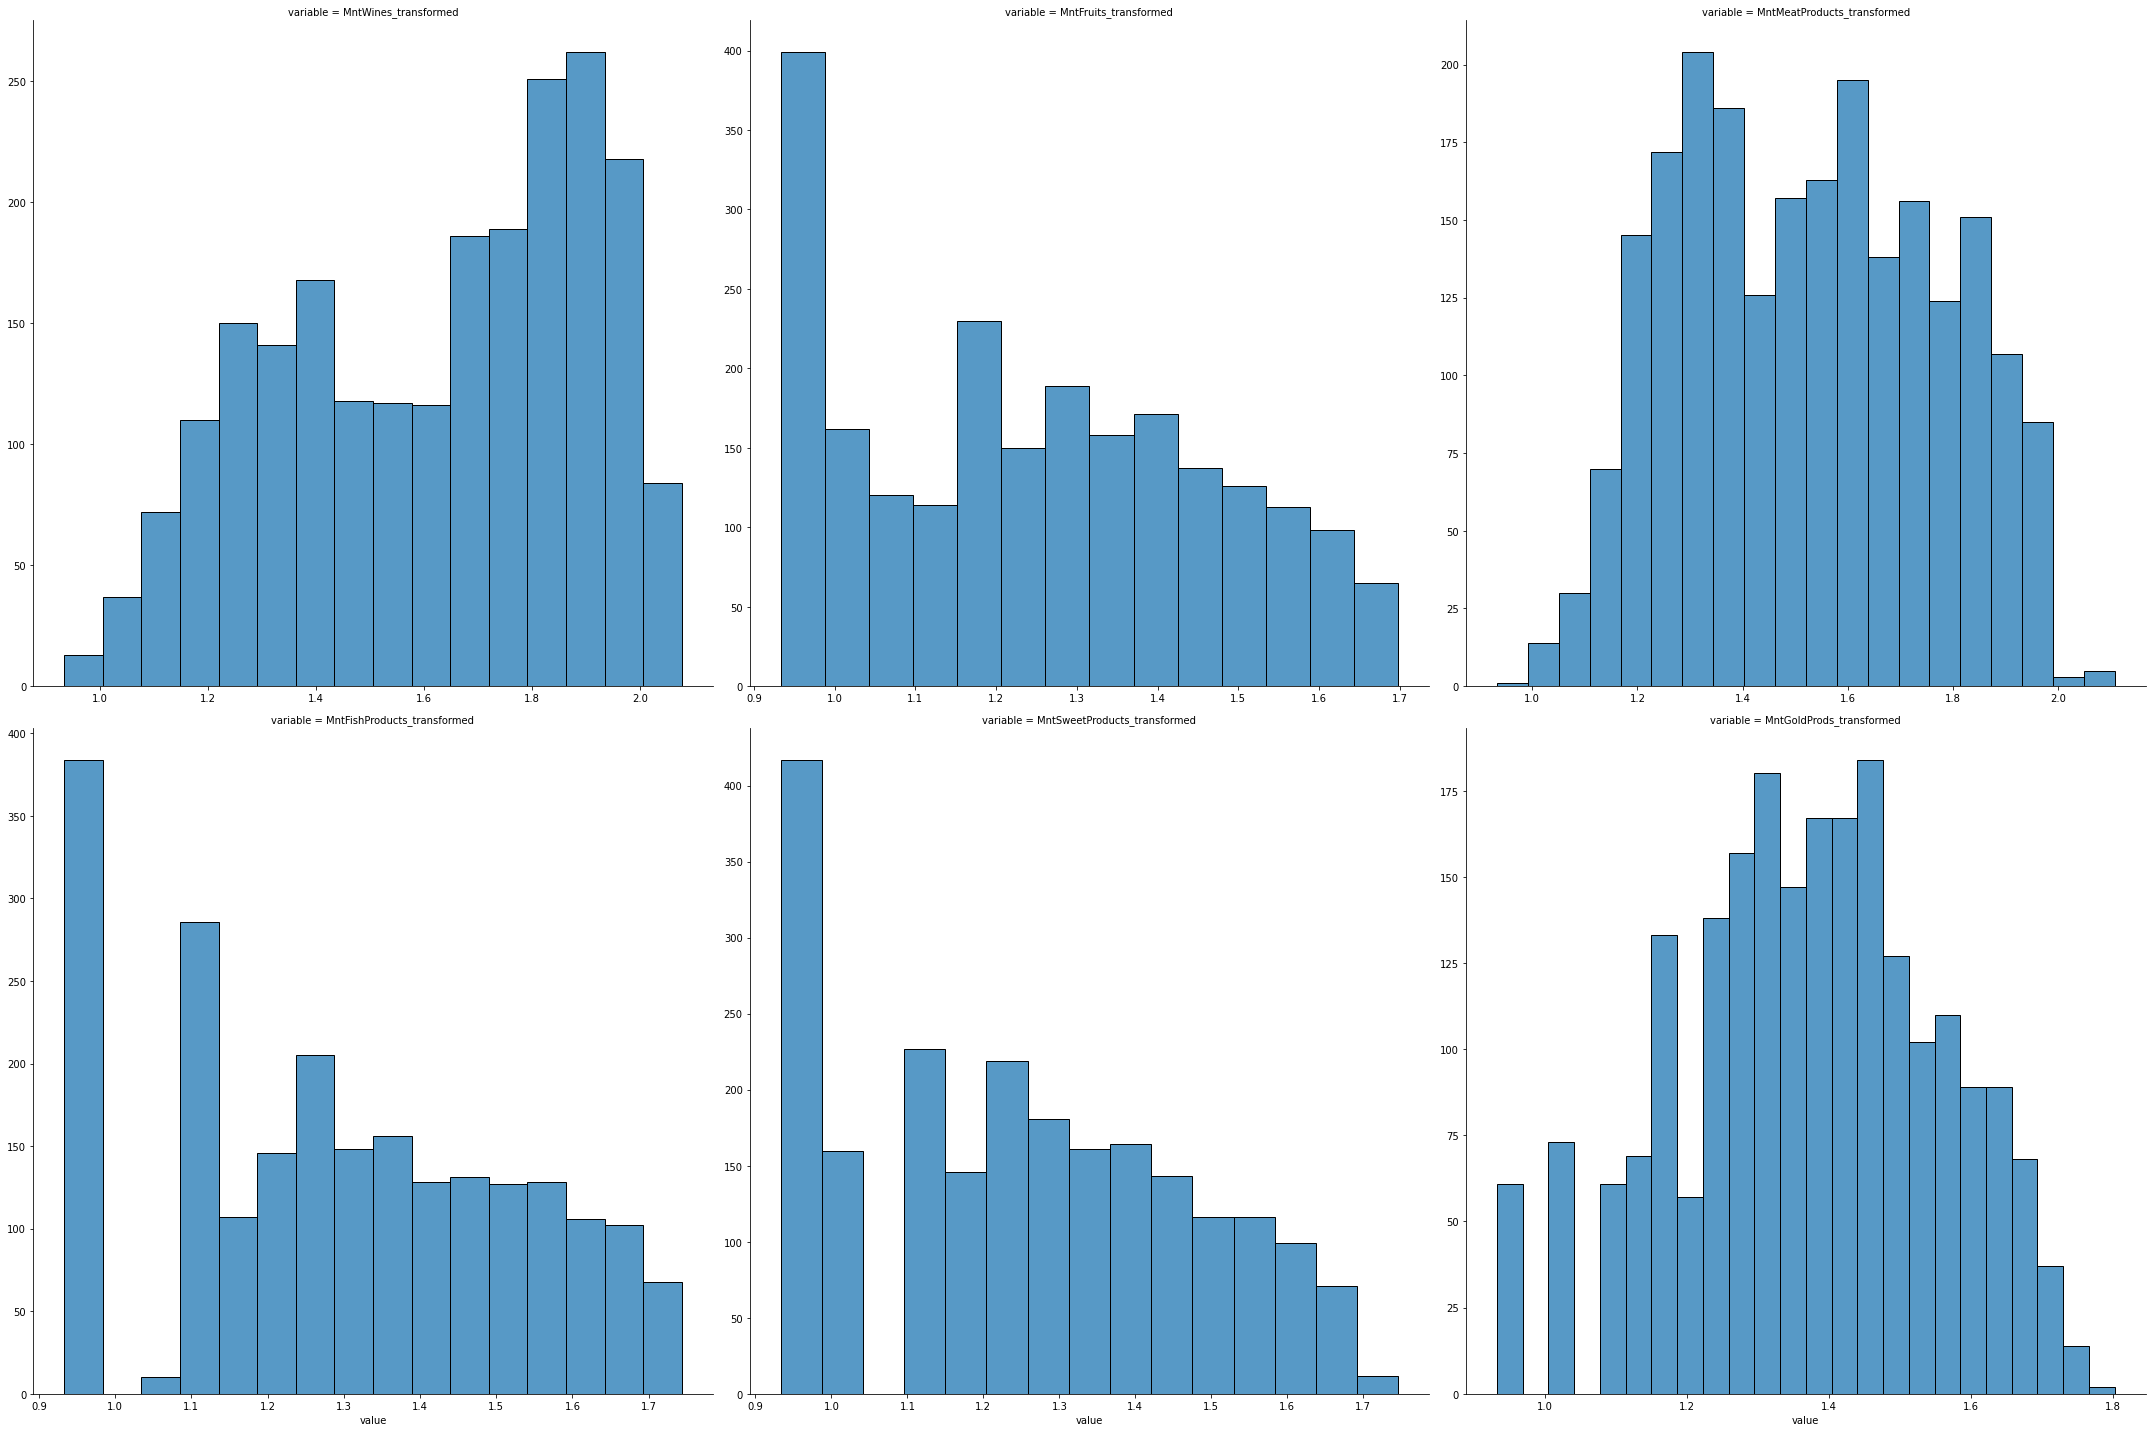

In [590]:
data_distribution = pd.DataFrame(data=transformed_df, columns=['MntWines_transformed','MntFruits_transformed','MntMeatProducts_transformed',
                                                   'MntFishProducts_transformed','MntSweetProducts_transformed',
                                                   'MntGoldProds_transformed'
                                                  ])

nd = pd.melt(data_distribution, value_vars = data_distribution )
n1 = sns.FacetGrid (nd, col='variable', col_wrap = 3, height = 10, sharex=False, sharey = False)
n1 = n1.map(sns.histplot, 'value')

On to the count data

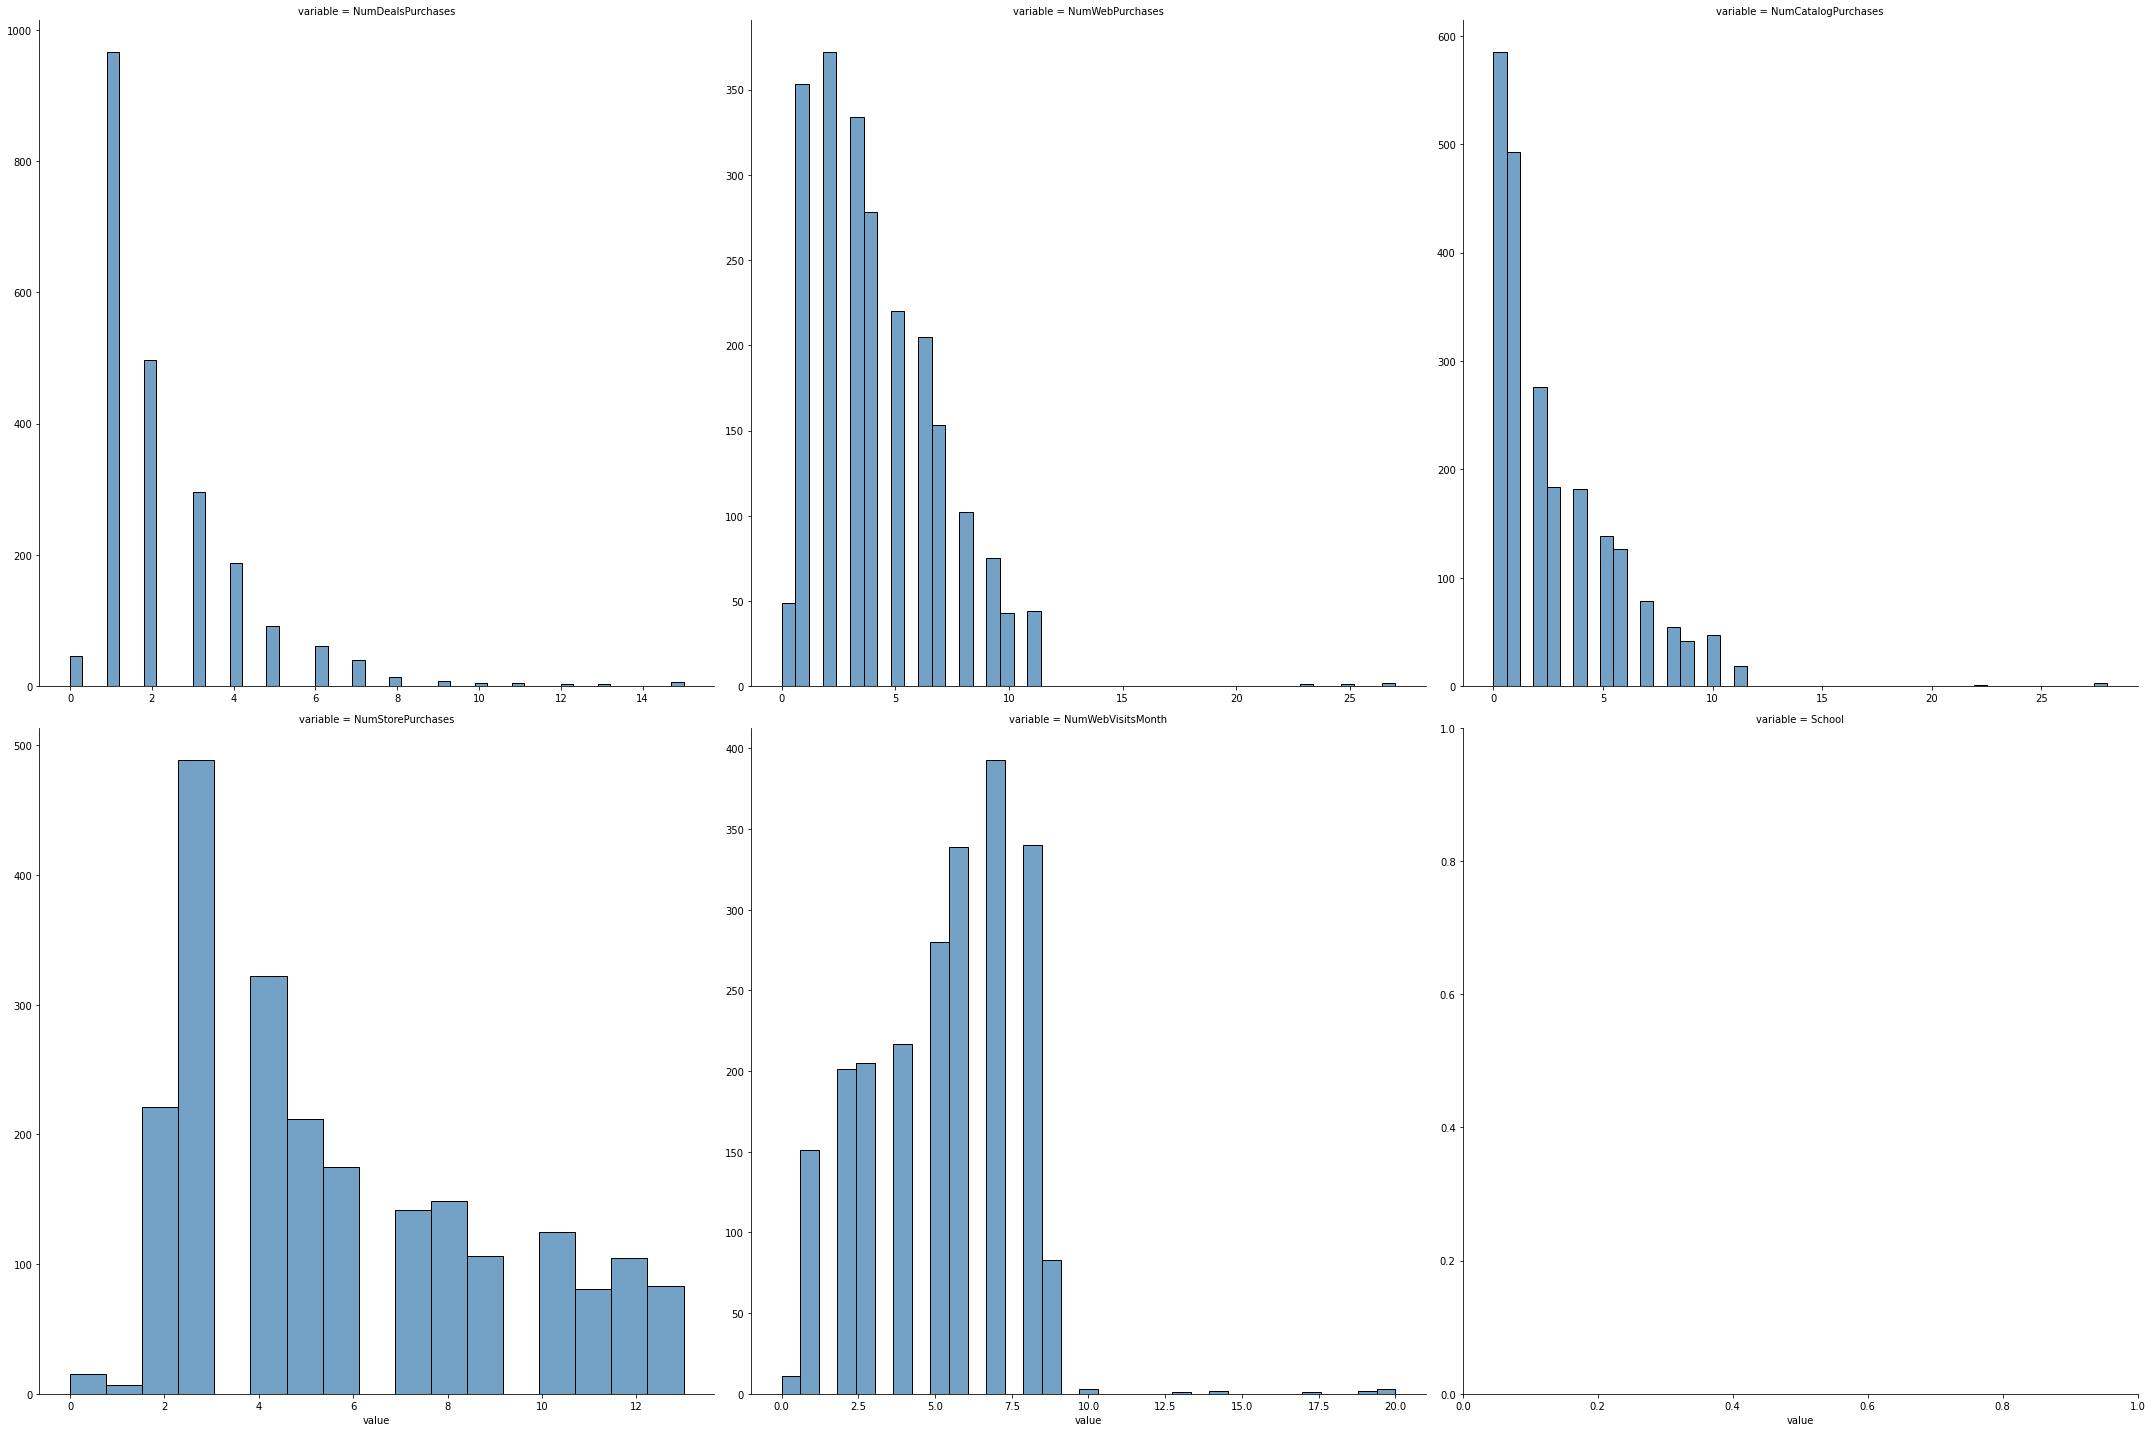

In [591]:
data_distribution = pd.DataFrame(data=df, columns=['NumDealsPurchases','NumWebPurchases','NumCatalogPurchases',
                                                   'NumStorePurchases','NumWebVisitsMonth', 'School'
                                                  ])

nd = pd.melt(data_distribution, value_vars = data_distribution )
n1 = sns.FacetGrid (nd, col='variable', col_wrap = 3, height = 10, sharex=False, sharey = False)
n1 = n1.map(sns.histplot, 'value',color='steelblue')

NumCatalogPurchases has a lot of zeros. Create dummy variable "NumCatalogPurchases_zero" that is 1 when NumCatalogPurchases is zero.

In [592]:
transformed_df['NumCatalogPurchases_zero'] = np.select([df['NumCatalogPurchases'].eq(0)],[1],
                             default = 0)

### Section 2: Statistical Analysis

#### Questions:
- What factors are significantly related to the number of store purchases? 
- Does US fare significantly better than the Rest of the World in terms of total purchases?
- Your supervisor insists that people who buy gold are more conservative. Therefore, people who spent an above average amount on gold in the last 2 years would have more in store purchases. Justify or refute this statement using an appropriate statistical test
- Fish has Omega 3 fatty acids which are good for the brain. Accordingly, do "Married PhD candidates" have a significant relation with amount spent on fish?
- Is there a significant relationship between geographical regional and success of a campaign?

#### Useful functions:

In [593]:
def ols_bivariate(X,Y, data):
    '''This function takes a string "X", string "Y" (representing the independent and dependent variables
    respectively), a dataframe "data" and performs bivariate OLS regression. Given the status of the "verbose" and "residualPlots" flags,
    the regression summary will be printed and the residual plots plotted. A tuple (regressor's tvalue,
    regressor's coefficient, rsquared value) is returned.'''
    bi_formula = str(Y) + " ~ " +  str(X)
    bi_result = smf.ols(bi_formula, data=data).fit()
    if verbose:
        print(bi_result.summary())
    if residualPlots:
        # create regression plots
        fig = plt.figure(figsize=(14, 8))
        fig = sm.graphics.plot_regress_exog(bi_result,str(X), fig=fig)
    return (bi_result.tvalues.iloc[1], bi_result.params[1],bi_result.rsquared)

In [594]:
def log_bivariate(X,Y):
    '''This function takes a string "X" and string "Y", representing the independent and dependent variables
    respectively, and performs bivariate logistic regression.'''
    x = df[str(X)]
    y = df[str(Y)]
    x = sm.add_constant(x)
    log_bi_result = sm.Logit(y,x).fit()
    if verbose:
        print(log_bi_result.summary())

In [595]:
def buildFormula(X,Y):
    ''' This function takes a string "Y" and a list of strings "X" that are the names of columns in the dataframe.
    From this, a regression formula string is built and returned for use in statsmodels regression.'''
    X_string = ""
    for x in X:
        X_string += str(x)
        if x != X[len(X)-1]:
            X_string += " + "
    multi_formula = Y + " ~ " + X_string
    return multi_formula

##### Question: What factors are significantly related to the number of store purchases?

Create correlation matrix:

In [596]:
correlation_matrix = transformed_df.corr(method='pearson')

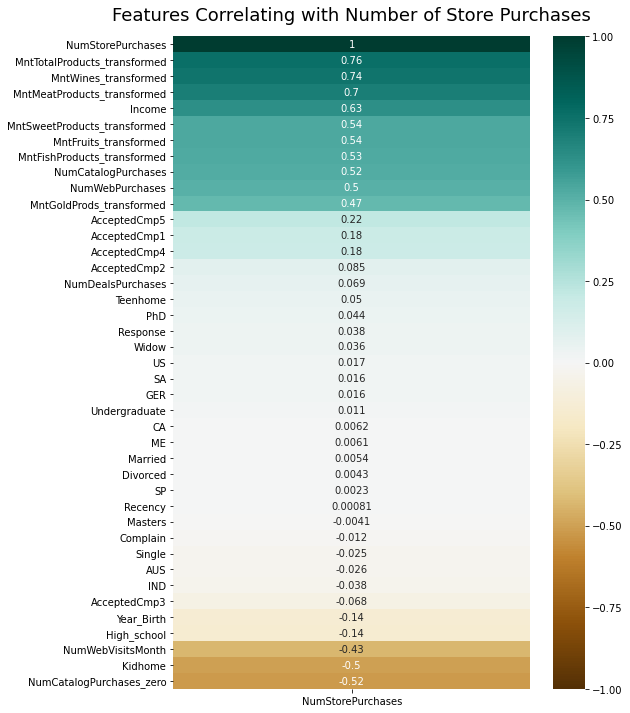

In [597]:
# create data visualization of features correlating with number of store purchases
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(correlation_matrix[['NumStorePurchases']].sort_values(by='NumStorePurchases', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Number of Store Purchases', fontdict={'fontsize':18}, pad=16);

In [598]:
# save correlation matrix to csv if saveCorrelationMatrix flag is true
if saveCorrelationMatrix:
    correlation_matrix.to_csv('correlationMatrix.csv')

In [599]:
# NumStorePurchases is count data. Add log to NumStorePurchases.
transformed_df['NumStorePurchases_log'] = np.log(transformed_df['NumStorePurchases']+0.5)

In [600]:
# parsimonious multiple OLS model of factors needed to predict the number of store purchases
results = smf.ols('NumStorePurchases_log ~ MntFishProducts_transformed + MntTotalProducts_transformed' + 
                  '+ MntWines_transformed + Income + MntFruits_transformed + MntSweetProducts_transformed +'
                  +'NumDealsPurchases + NumCatalogPurchases_zero + NumCatalogPurchases + NumWebVisitsMonth + AcceptedCmp3 + Response',
                  data=transformed_df).fit()
if verbose:
    print(results.summary())

- Unsurprisingly, the amounts (by product category) purchased and modes of purchase are significantly, positively correlated with the number of store purchases. Customers who purchase more wine and meat are more likely to have more in store purchases. The same is true of customers who purchase more fruits, fish, sweets, and gold products but to a lesser extent. This can be explained by the fact that our wine and meat products are our best selling products.
- Also unsurprisingly, customers with higher incomes are more likely to have more in store purchases. This is because people with higher incomes have a higher propensity to consume, in general.
- People who have more web visits per month are significantly, negatively correlated with having less in store purchases. However, this does not indicate a trade-off between in store purchases and web purchases--customers who have more in store purchases also have more web purchases.
- A very important observation is that customers with non-teen, children living with them are likely to have less in store purchases. Crucially, customers with more children are less profitable customers. They, overall, purchase less.  
##### Follow up question:
1) What factors are significantly related to Kidhome?

##### Follow up question: What factors are significantly related to Kidhome?

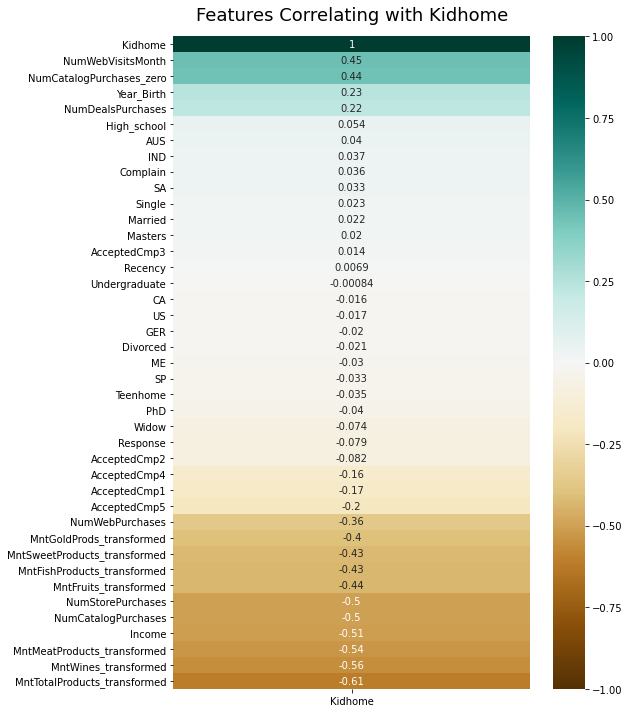

In [601]:
# create data visualization of features correlating with Kidhome
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(correlation_matrix[['Kidhome']].sort_values(by='Kidhome', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Kidhome', fontdict={'fontsize':18}, pad=16);

Customers who have more (or any) children living with them, as determined before, generally purchase less. However, there is a crucial observation we can make: they are unresponsive to our advertising. Customers with more children have lower income. They browse our website frequently and look for deals. Yet they are not purchasing from us. They are unresponsive to our advertising. Because approximately 40% of our customers have kids in their household, targeting those households is advised.  

##### Question: Does US fare significantly better than the rest of the world in terms of total purchases?

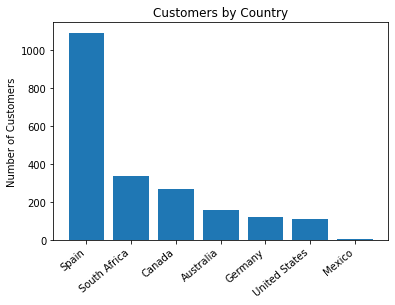

In [602]:
# create data visualization to show differences in number of customers by country
AUS = df['AUS'].sum()
CA = df['CA'].sum()
GER = df['GER'].sum()
IND = df['IND'].sum()
ME = df['ME'].sum()
SA = df['SA'].sum()
SP = df['SP'].sum()
US = df['US'].sum()

values_sorted = np.array([SP,SA,CA,AUS,GER,US,ME])
labels_sorted = ['Spain',"South Africa","Canada","Australia",'Germany',"United States","Mexico"]

fig, ax = plt.subplots()
ax.bar(labels_sorted,values_sorted)
ax.set_ylabel('Number of Customers')
ax.set_title("Customers by Country")
plt.setp(ax.get_xticklabels(),rotation=40,ha='right')
plt.show()

In [603]:
# regress countries, individually, on amount of total purchases 
labels = ['AUS','CA','GER','IND','ME','SA','SP','US']
Y = 'MntTotalProducts_transformed'
for X in labels:
    ols_bivariate(X,Y,transformed_df)

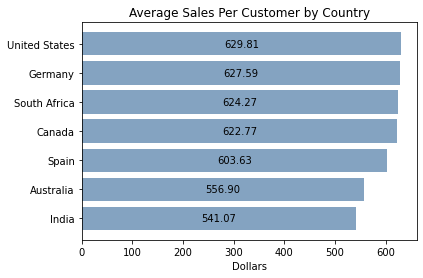

In [604]:
# create data visualization to show which country's customers spend more money on average.
CountryDF = pd.DataFrame().assign(AUS = df['AUS'],CA = df['CA'],GER = df['GER'],IND = df['IND'],ME = df['ME'],SA = df['SA'],SP = df['SP'],US = df['US'], MntTotalProduct = df['MntTotalProducts'])

CountryDF['AUSMntTotal'] = df.query("AUS == 1")['MntTotalProducts']
CountryDF['CAMntTotal'] = df.query("CA == 1")['MntTotalProducts']
CountryDF['GERMntTotal'] = df.query("GER == 1")['MntTotalProducts']
CountryDF['INDMntTotal'] = df.query("IND == 1")['MntTotalProducts']
# CountryDF['MEMntTotal'] = df.query("ME == 1")['MntTotalProducts'] #exclude Mexico due to n =3
CountryDF['SAMntTotal'] = df.query("SA == 1")['MntTotalProducts']
CountryDF['SPMntTotal'] = df.query("SP == 1")['MntTotalProducts']
CountryDF['USMntTotal'] = df.query("US == 1")['MntTotalProducts']

AUS = CountryDF['AUSMntTotal'].sum()/df['AUS'].sum()
CA = CountryDF['CAMntTotal'].sum()/df['CA'].sum()
GER = CountryDF['GERMntTotal'].sum()/df['GER'].sum()
IND = CountryDF['INDMntTotal'].sum()/df['IND'].sum()
# ME = CountryDF['MEMntTotal'].sum()/df['ME'].sum()
SA = CountryDF['SAMntTotal'].sum()/df['SA'].sum()
SP = CountryDF['SPMntTotal'].sum()/df['SP'].sum()
US = CountryDF['USMntTotal'].sum()/df['US'].sum()

values = [AUS,CA,GER,IND,SA,SP,US]
# values = [ME,AUS,CA,GER,IND,SA,SP,US]
values.sort()
countries = ['India','Australia','Spain',"Canada","South Africa",'Germany','United States']
# countries = ['India','Australia','Spain',"Canada","South Africa",'Germany','United States','Mexico']
thisDF = {}
thisDF['countries'] = countries
thisDF['values'] = values
thisDF = pd.DataFrame().from_dict(thisDF)

fig, ax = plt.subplots()
g=ax.barh(thisDF['countries'], thisDF['values'],color=(0.2, 0.4, 0.6, 0.6))
ax.set_xlabel("Dollars")
ax.set_title('Average Sales Per Customer by Country')
ax.bar_label(g,label_type="center",fmt='%.2f') # This provides the labelling, this only available in newer matploblib version. Copy and paste into command line  "pip install -U matplotlib"
plt.show()


The majority our customers live in Spain. The United States has the second fewest number of customers (second to Mexico with only 3 customers living there). However, the average customer in the United States spends more on our products than the average customer of any other country. (note: Mexico was excluded in this because n=3 does not provide enough data to support reasonable inference.) Having an increased enrollment in the United States could be beneficial however, country of residence is not a statistically significant predictor of the amount of total purchases. Given the cost of foreign direct investment, I recommend hesitancy before any attempts to increase enrollment in any country. 

##### Question: Your supervisor insists that people who buy gold are more conservative. Therefore, people who spent an above average amount on gold in the last 2 years would have more in store purchases. Justify or refute this statement using an appropriate statistical test.

In [605]:
# create dataframe with NumStorePurchases, MntGoldProds, and a dummy variable ('AboveAvgMntGoldProds') that is 1 if
# customer spent above average amount on gold products in past two years. 
averageGoldPurchases = (df['MntGoldProds'].sum())/2208
goldVSStorePurchases = pd.DataFrame().assign(NumStorePurchases = df['NumStorePurchases'])
goldVSStorePurchases['aboveAvgMntGoldProds'] = np.select([df['MntGoldProds'].gt(averageGoldPurchases)],[1],default = 0)
goldVSStorePurchases['MntGoldProds'] = df['MntGoldProds']
goldVSStorePurchases['NumStorePurchases_log'] = transformed_df['NumStorePurchases_log']


In [606]:
X = 'aboveAvgMntGoldProds'
Y = 'NumStorePurchases_log'
ols_bivariate(X,Y,goldVSStorePurchases)

(21.138162091587628, 0.4808250016604716, 0.16692253495687004)

There is evidence that people who spend an above average amount on gold products have more in store purchases. This does not necessarily imply that people who buy gold products are more conservative

In [607]:
# transformed variable no longer needed
transformed_df.drop('NumStorePurchases_log',inplace=True,axis=1)

##### Question: Fish has Omega 3 fatty acids which are good for the brain. Accordingly, do "Married PhD candidates" have a significant relation with amount spent on fish? 

In [608]:
MPhD_on_FishProducts = smf.ols('MntFishProducts_transformed ~ Married + PhD + Married*PhD',data=transformed_df).fit()
if verbose:
    print(MPhD_on_FishProducts.summary())

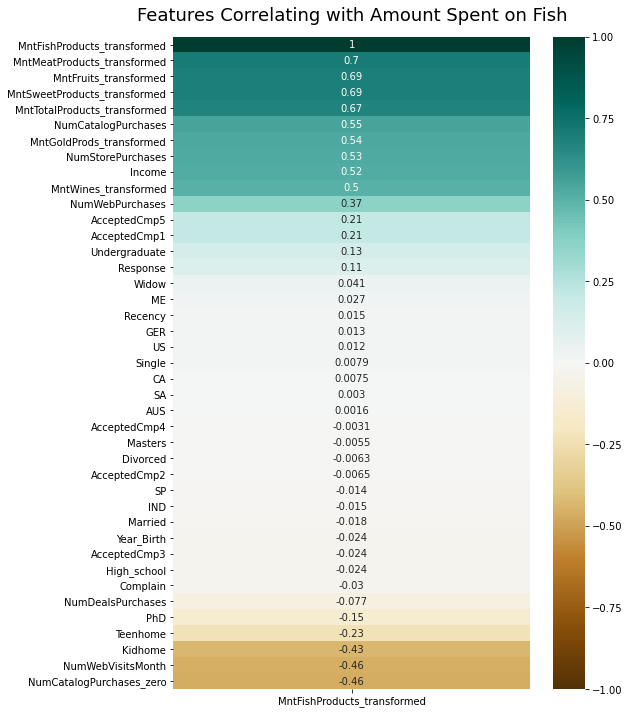

In [609]:
# create data visualization of features correlating with number of store purchases
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(correlation_matrix[['MntFishProducts_transformed']].sort_values(by='MntFishProducts_transformed', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Amount Spent on Fish', fontdict={'fontsize':18}, pad=16);

There is not sufficient statistical evidence to conclude that customers who are married with a PhD spend more on fish products. However, there is evidence that customers with PhDs spend LESS on our fish products. This provides evidence AGAINST the implied hypothesis that people who buy more fish are smarter. 

The most complementary products, in order of signficance, are other meats, fruits, sweets, gold line, and wines.

##### Question: Is there a significant relationship between geographical regional and success of a campaign?

In [610]:
# perform logistic regression for each campaign on each country
regions = ['AUS','CA','GER','IND','ME','SA','SP','US']
campaigns= ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']
for X in regions:
    for Y in campaigns:
        log_bivariate(X,Y)

Optimization terminated successfully.
         Current function value: 0.237507
         Iterations 7
         Current function value: 0.070273
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.261240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.265026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.259114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.238003
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070910
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.265714
         Iterations 6
Optimization ter

Very few conclusions can be drawn on the relationship between geographical region and success of a campaign. Customers in India are unlikely to have responded to any advertising campaign. Customers in Mexico were likely to respond, but we only have 3 customers in Mexico. The most useful conclusion is that advertising campaign effectiveness is independent of a customers country unless they live in India. 

### Section 3: Data Visualization

#### Questions:
- Which marketing campaign is most successful?
- What does the average customer look like for this company?
- Which product categories are complementary? 
- Which products are performing best?
- Which channels are underperforming?
- Are we gaining customers? 

##### Question: Which marketing campaign is most successful?

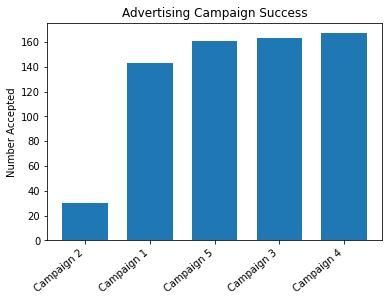

In [611]:
AcceptedCmp1 = df['AcceptedCmp1'].sum()
AcceptedCmp2 = df['AcceptedCmp2'].sum()
AcceptedCmp3 = df['AcceptedCmp3'].sum()
AcceptedCmp4 = df['AcceptedCmp4'].sum()
AcceptedCmp5 = df['AcceptedCmp5'].sum()
values = np.array([AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5])
values.sort()
labels = ['Campaign 2','Campaign 1','Campaign 5','Campaign 3','Campaign 4']
fig, ax = plt.subplots()
ax.bar(labels,values,width=.7)
ax.set_ylabel('Number Accepted')
ax.set_title("Advertising Campaign Success")
plt.setp(ax.get_xticklabels(),rotation=40,ha='right')
plt.show()

Campaign 4 is most successful. However, the difference in effectiveness of campaigns 1,5,3, and 4, are practically (and likely statistically) insignficant--they are all equally effective. Campaign 2, on the other hand, did not do well. Very few people responded to it.

##### What does the average customer look like for this company?

In [612]:
df.describe().iloc[1]

Year_Birth              1968.888889
Income                 51946.786753
Kidhome                    0.444892
Teenhome                   0.506720
Recency                   49.154122
MntWines                 304.065412
MntFruits                 26.244624
MntMeatProducts          166.957885
MntFishProducts           37.415771
MntSweetProducts          27.099014
MntGoldProds              43.841398
NumDealsPurchases          2.323925
NumWebPurchases            4.085573
NumCatalogPurchases        2.660394
NumStorePurchases          5.794803
NumWebVisitsMonth          5.319892
AcceptedCmp3               0.073029
AcceptedCmp4               0.074821
AcceptedCmp5               0.072133
AcceptedCmp1               0.064068
AcceptedCmp2               0.013441
Response                   0.148746
Complain                   0.008961
High_school                0.024194
Masters                    0.255376
PhD                        0.216398
Undergraduate              0.504032
Divorced                   0

The average customer was born in 1969, has an income just under $52,000, has either a kid or a teen living in their household, has an undergraduate degree and is married. Approximately half of the money they spend on our product is wines. Approximately 28 percent is spent on meats. The remainder is spent on gold products, fish products, sweet products, and fruit products. In two years, they purchase from our store almost 6 times and purchase online about 4. The most recent purchase being 50 days ago. 

#### Question: Which products are performing best?

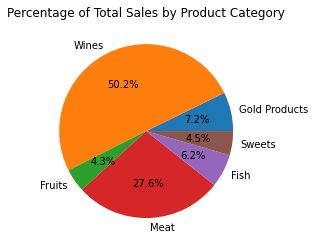

In [613]:
# create pie chart to illustrate each product category's share of total sales
mntGoldProdsSum = df['MntGoldProds'].sum()
mntWinesSum = df['MntWines'].sum()
mntFruitsSum = df['MntFruits'].sum()
mntMeatProductsSum = df['MntMeatProducts'].sum()
mntFishProductsSum = df['MntFishProducts'].sum()
mntSweetProductsSum = df['MntSweetProducts'].sum()

x = np.array([mntGoldProdsSum,mntWinesSum,mntFruitsSum,mntMeatProductsSum,mntFishProductsSum,mntSweetProductsSum])
mylabels = ['Gold Products','Wines','Fruits','Meat','Fish','Sweets']
plt.pie(x, labels = mylabels, autopct = '%1.1f%%')
plt.title("Percentage of Total Sales by Product Category")
plt.show()

Wine sales represent the majority of our sales. Meat sales represent 28% of our sales. The remaining 22% is comprised of gold products, fish, sweets, and fruits.

##### Question: Which product categories are complementary? 

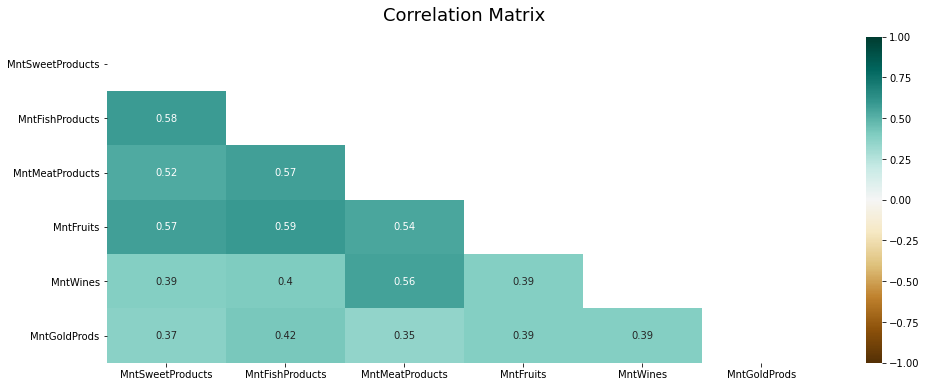

In [614]:
corrMatrix = pd.DataFrame().assign(MntSweetProducts = df['MntSweetProducts'], MntFishProducts = df['MntFishProducts'],MntMeatProducts = df['MntMeatProducts'],MntFruits = df['MntFruits'],MntWines = df['MntWines'], MntGoldProds = df['MntGoldProds'])

plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(corrMatrix.corr(), dtype=bool))
heatmap = sns.heatmap(corrMatrix.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':18}, pad=16);

- Fruits and fish products pair well. 
- Fish and sweet products pair well. 
- Fish and meat products pair well.
- Wines and meat products pair well.

This should be taken into consideration when deciding the layout of our stores

##### Question: Which channels are underperforming?

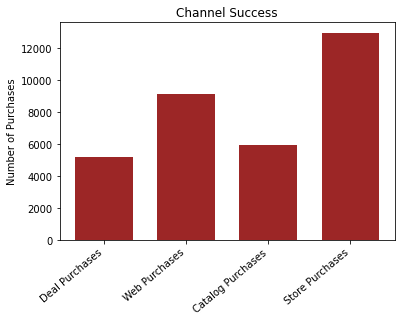

In [615]:
# create bar chart to illustrate channel success
NumDealsPurchases = df['NumDealsPurchases'].sum()
NumWebPurchases = df['NumWebPurchases'].sum()
NumCatalogPurchases = df['NumCatalogPurchases'].sum()
NumStorePurchases = df['NumStorePurchases'].sum()

values = np.array([NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases])
labels = ['Deal Purchases','Web Purchases','Catalog Purchases','Store Purchases']
fig, ax = plt.subplots()
ax.bar(labels,values,width=.7, color = 'darkred', alpha = 0.85)
ax.set_ylabel("Number of Purchases")
ax.set_title("Channel Success")
plt.setp(ax.get_xticklabels(),rotation=40,ha='right')

plt.show()


In store purchases is our dominant mode of sale. A significant amount of purchases are made online. Deal and catalog purchases are substantial. Having access to time series data would reveal trends in purchase mode.

##### Question: Are we gaining customers? 

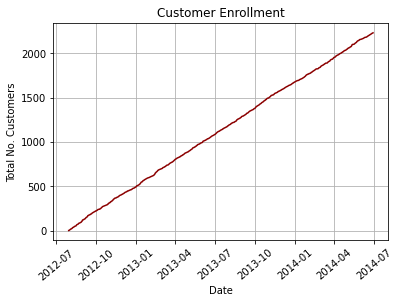

In [616]:
# Customer Enrollment graph
date_counts = df['Dt_Customer'].dt.date.value_counts()
unique_dates = df['Dt_Customer'].unique()
date_counts = date_counts.to_frame()
date_counts['Date'] = date_counts.index
date_counts = date_counts.sort_values(by="Date")
date_counts["Cum_Sum"] = date_counts['Dt_Customer'].cumsum()

plt.plot(date_counts["Cum_Sum"], color = 'darkred')

plt.xlabel("Date")
plt.ylabel("Total No. Customers")
plt.xticks(rotation=40)
plt.title("Customer Enrollment")
plt.grid()
plt.show()

Customer enrollment appears to be increasing at a steady rate. There is no cause for concern.

### Section 4: Predictive Model

#### Objective:
Build a predictive model that takes a customers attributes and predicts if they respond to the final advertising campaign. 

In [617]:
#create new dataframe that consists of variables needed for model
new_df = transformed_df.copy()
excluded_vars = ["ID","Dt_Customer","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5","AcceptedCmp1","AcceptedCmp2","NoResponse"]
data_vars=new_df.columns.values.tolist()
to_keep=[i for i in data_vars if i not in excluded_vars]
data_final=new_df[to_keep]

In [618]:
#separate into x and y
X = data_final.loc[:, data_final.columns != 'Response']
y = data_final.loc[:, data_final.columns == 'Response']

In [619]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [620]:
#fix imbalanced data
os = SMOTE(k_neighbors=16)

columns = X_train.columns
os_data_X,os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Response'])

In [621]:
#resplit
OS_X_train, OS_X_test, OS_y_train, OS_y_test = train_test_split(os_data_X, os_data_y, test_size=0.4,random_state=0)

In [622]:
#remove insignificant features and train random forest classifier
rfc = RandomForestClassifier(n_estimators=40,criterion='log_loss') 
rfe = RFE(rfc, n_features_to_select=22) 
rfe.fit(OS_X_train, np.ravel(OS_y_train))
rfc.fit(rfe.transform(OS_X_train), np.ravel(OS_y_train))

RandomForestClassifier(criterion='log_loss', n_estimators=40)

In [623]:
#print list of features in model
counter = 0
feature_list = []
# print(X.columns)
for feature in rfe.get_support():
    if feature:
        feature_list.append(X.columns[counter])
    counter += 1
print("List of features included in model:")
print(feature_list)

List of features included in model:
['Year_Birth', 'Income', 'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Masters', 'Undergraduate', 'Married', 'Single', 'SP', 'MntFruits_transformed', 'MntWines_transformed', 'MntMeatProducts_transformed', 'MntFishProducts_transformed', 'MntGoldProds_transformed', 'MntTotalProducts_transformed', 'MntSweetProducts_transformed', 'NumCatalogPurchases_zero']


In [624]:
#get accuracy score
rfc.score(rfe.transform(X_test),y_test)

0.8331466965285554

In [625]:
#make predictions
y_predicted = rfc.predict(rfe.transform(X_test))

Text(69.0, 0.5, 'Truth')

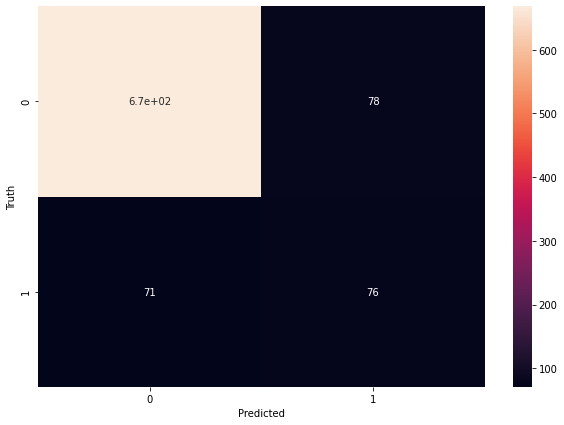

In [626]:
#create confusion matrix
cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [627]:
f1_score(y_test, y_predicted)

0.5049833887043189

##### Model Evaluation:
The model predicts response correctly approximately 84% of the time but is flawed. The data are highly imbalanced. 332 customers responded to the final campaign, while 1901 customers did not. Even after balancing the training data, fine tuning parameters, trying different classification models, the problem persists. The model only correctly categorizes a response about 52% of the time.

##### Question: Are there any more observations we can make about who our advertising campaign reached?

Regress each variable on 'Response' individually

In [628]:
# variables to be considered
X = ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain',
       'High_school', 'Masters', 'PhD', 'Undergraduate', 'Divorced', 'Married',
       'Single', 'Widow', 'AUS', 'CA', 'GER', 'IND', 'ME', 'SA', 'SP', 'US',
       'MntFruits_transformed', 'MntWines_transformed', 'MntMeatProducts_transformed',
       'MntFishProducts_transformed', 'MntGoldProds_transformed', 'MntTotalProducts_transformed',
       'MntSweetProducts_transformed', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth']
Y = 'Response'

In [629]:
# carry out regressions
ols_stored_results = {}
for x in X:
    t_value_coefficient_rsquared = ols_bivariate(x,Y,transformed_df)
    ols_stored_results[x] = t_value_coefficient_rsquared
# sort the stored results by statistical significance 
results_sorted = dict(sorted(ols_stored_results.items(), key=lambda item: abs(item[1][0]),reverse=True))

In [630]:
# add results to their respective lists
keys = []
t_values = []
coefficients = []
for key,value in results_sorted.items():
    if value[0] < 2 and value[0] > -2:
        continue
    keys.append(key)
    t_values.append((value[0]))
    coefficients.append((value[1]))

Create data visualization to show each feature's statistical significance, size, and direction

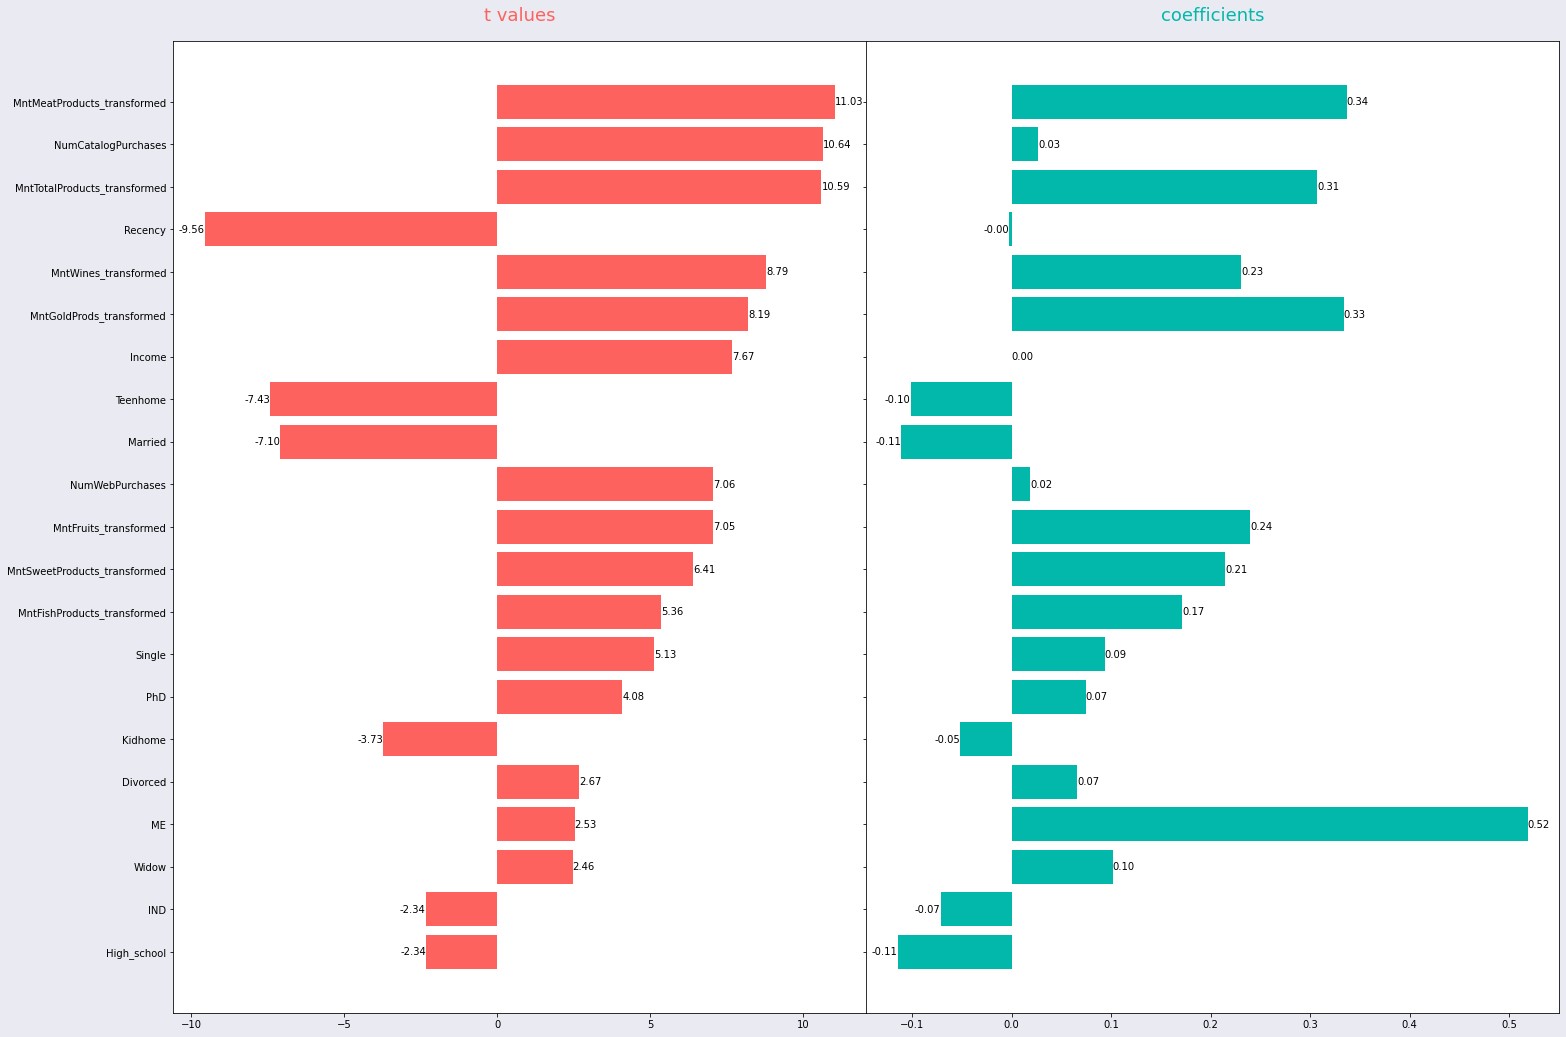

In [631]:
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = keys
column0 = t_values
column1 = coefficients
title0 = 't values'
title1 = 'coefficients'

fig, axes = plt.subplots(figsize=(25,15), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

i = axes[0].barh(index, column0, align='center', color=color_red, zorder=20)
axes[0].set_title(title0, fontsize=18, pad=20, color=color_red)
axes[0].bar_label(i,label_type="edge",fmt='%.2f')

j = axes[1].barh(index, column1, align='center', color=color_blue, zorder=20)
axes[1].set_title(title1, fontsize=18, pad=20, color=color_blue)
axes[1].bar_label(j,label_type="edge",fmt='%.2f')

plt.gca().invert_yaxis()

axes[0].set(yticks=keys, yticklabels=keys)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black')
plt.subplots_adjust(wspace=0, top=1, bottom=0.1, left=0.18, right=0.95)


The advertising campaign was most successful on those who already frequently purchased from us. Specifically, those who buy a lot of gold products, meat, and wines. Those who are married and have teens in the household were less likely to respond. This is a demographic we struggle with and future advertising campaigns should target them. Those who are more educated were more likely to respond. 